# Deep learning : projet d'IA

**Author: alice.petit@soprasterianext.com**

**Version**: 2025/11

Pour toute remarque ou suggestion, n'hésitez pas à me contacter.

$\newcommand{\underbr}[2]{\underbrace{#1}_{\scriptscriptstyle{#2}}}$

## <font color=darkred> **Objectif de ce TP** :
Des professeurs veulent lire automatiquement les chiffres notés sur leurs copies.
Ils ne peuvent pas utiliser les copies pour des questions d'anonimisation des données.

Nous pouvons donc utiliser un jeu de données semblable pour entrainer notre modèle. On va utiliser la base de données MNIST.

On va entrainer un classifieur CNN à reconnaitre les 10 chiffres qui existent (0, 1, 2, 3, 4, 5, 6, 7, 8, 9).

Puis on va appliquer des métriques.

### Les métriques à appliquer
- Matrice de confusion
- l'accuracy
- la pertinence
- le rappel
- le score F1

## Chargement des données MNIST

In [ ]:
import pandas as pd

splits = {'train': 'mnist/train-00000-of-00001.parquet', 'test': 'mnist/test-00000-of-00001.parquet'}
df_train = pd.read_parquet("hf://datasets/ylecun/mnist/" + splits["train"])
df_test = pd.read_parquet("hf://datasets/ylecun/mnist/" + splits["test"])

'HTTPSConnectionPool(host='us.gcp.cdn.hf.co', port=443): Read timed out.' thrown while requesting GET https://huggingface.co/datasets/ylecun/mnist/resolve/main/mnist/train-00000-of-00001.parquet
Retrying in 1s [Retry 1/5].


In [ ]:
X_train = df_train["image"][:1000]
y_train = df_train["label"][:1000]

In [ ]:
# TODO visualiser ce que l'on a dans X_train et y_train
print("Type d'une image :", type(X_train.iloc[0]))
print("Label d'exemple :", y_train.iloc[0])

Type d'une image : <class 'dict'>
Label d'exemple : 5


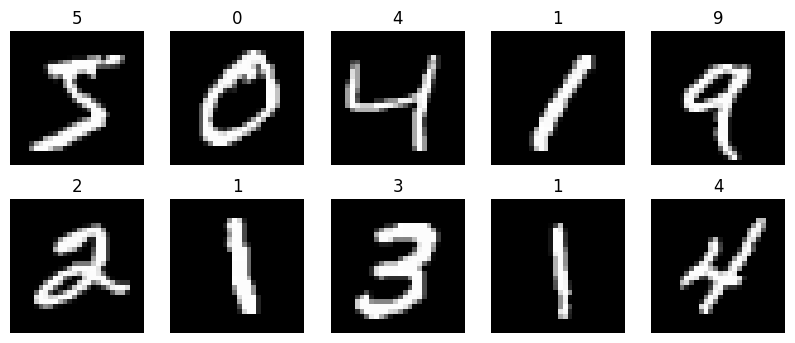

In [ ]:
# TODO Afficher les 10 première images avec leurs labels
import matplotlib.pyplot as plt
from PIL import Image
import io

#pour ouvrir une image
Image.open(io.BytesIO(X_train[0]["bytes"]))

plt.figure(figsize=(10,4))

for i in range(10):
    plt.subplot(2,5,i+1)
    img = Image.open(io.BytesIO(X_train[i]["bytes"]))
    plt.imshow(img, cmap="gray")
    plt.title(y_train.iloc[i])
    plt.axis("off")

plt.show()


## Mise en forme des données MNIST

In [ ]:
# TODO séparer les données d'entrainement en un jeu de validation et d'entrainement (100, 900)

X_train_raw, X_val_raw, y_train_raw, y_val_raw = train_test_split(
    X_train,
    y_train,
    test_size=0.1,
    random_state=42,
    stratify=y_train
)
len(X_train_raw), len(X_val_raw)

(900, 100)

In [ ]:
# TODO reshape les données pour qu'elles aients une shape de (nb_données, 28, 28, 1)

import numpy as np

def decode(img_dict):
    return np.array(Image.open(io.BytesIO(img_dict["bytes"])))

X_train = np.stack([decode(img) for img in X_train_raw]).reshape(-1, 28, 28, 1)
X_val   = np.stack([decode(img) for img in X_val_raw]).reshape(-1, 28, 28, 1)

X_train = X_train.astype("float32") / 255.0
X_val   = X_val.astype("float32") / 255.0


In [ ]:
print(X_train.shape)
print(X_val.shape)

(900, 28, 28, 1)
(100, 28, 28, 1)


In [ ]:
# TODO crée une fonction pour que tes images aient uniquement des pixels égaux à 0 ou 1
def apply_contrast(img):
    return (img > 0.5).astype("float32")

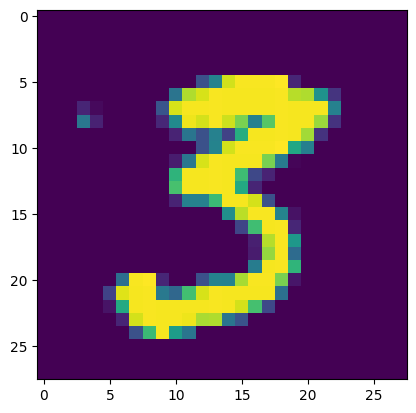

In [ ]:
plt.imshow((X_train[9].squeeze()))

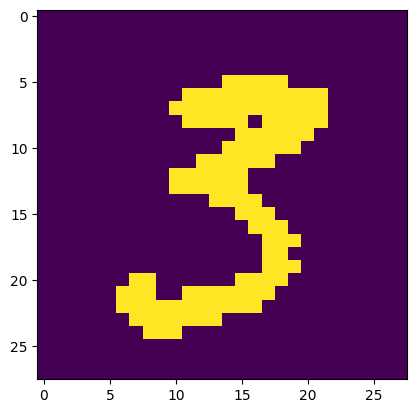

In [ ]:
image = apply_contrast(X_train[9])
plt.imshow(image.squeeze())

In [ ]:
# TODO transforme tes sorties Y en des vecteurs de taille 10 avec un 1 à l'index de la vérité

from keras.utils import to_categorical

Y_train = to_categorical(y_train_raw, num_classes=10)
Y_val   = to_categorical(y_val_raw, num_classes=10)


print("La valeur {} est encodée vers le vecteur {}".format(y_train_raw.iloc[0], Y_train[0]))
print("Valeur {} transformée en vecteur: {}".format(y_train_raw.iloc[20], Y_train[20]))

La valeur 9 est encodée vers le vecteur [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
Valeur 6 transformée en vecteur: [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


In [ ]:
for i in range(5):
    print(y_train_raw.iloc[i], "→", Y_train[i])

9 → [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
1 → [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
4 → [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
0 → [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
4 → [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]


## Création du modèle CNN

Les 2 premières couches de CNN auront du padding avec des filtres de taille (5,5).
La fonction d'activation "relu" sera utilisée par toutes les couches cachées du modèle.


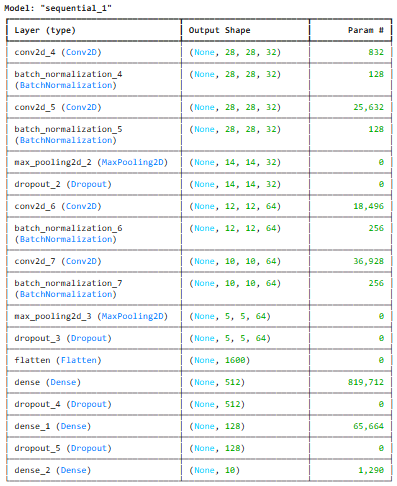

In [ ]:
# TODO crée un model keras de classification

# Librairies Keras pour la construction du réseau CNN
from keras.models import Model, Sequential
from keras.models import load_model
from keras.layers import Input, Conv2D, MaxPooling2D, BatchNormalization
from keras.layers import UpSampling2D, Dropout, Dense, Flatten

# Initialisation
model = Sequential()

# Ajoute les couches qui correspondent au schema ci-dessus

# Bloc 1
model.add(Conv2D(32, (5,5), padding="same", activation="relu", input_shape=(28,28,1)))
model.add(BatchNormalization())
model.add(Conv2D(32, (5,5), padding="same", activation="relu"))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.2))

# Bloc 2
model.add(Conv2D(64, (3,3), padding="same", activation="relu"))
model.add(BatchNormalization())
model.add(Conv2D(64, (3,3), padding="same", activation="relu"))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.2))

# Dense
model.add(Flatten())
model.add(Dense(512, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(10, activation="softmax"))


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


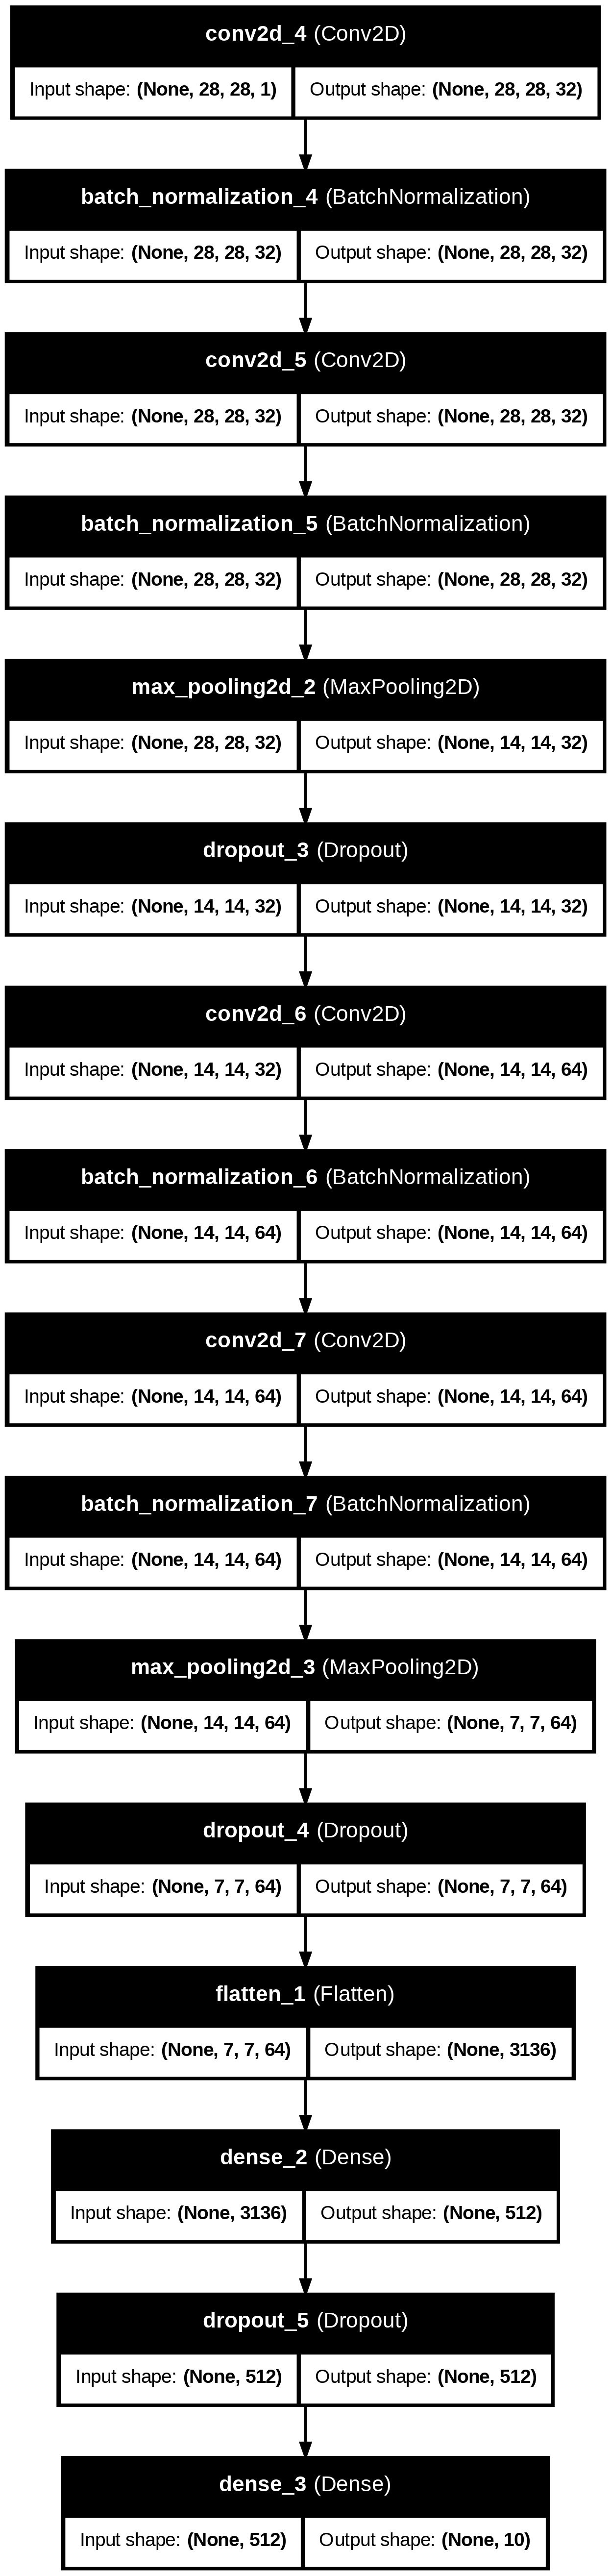

In [ ]:
from tensorflow.keras.utils import plot_model

# Visualisation du schémas de l'architecture de neurones
plot_model(model, show_shapes=True, show_layer_names=True)

In [ ]:
# Récapitulatif de l'architecture modèle
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 28, 28, 32)     │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 28, 28, 32)     │        25,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 14, 14, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │     1,606,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,693,930 (6.46 MB)

 Trainable params: 1,693,546 (6.46 MB)

 Non-trainable params: 384 (1.50 KB)

In [ ]:
# TODO utilise ADAM en optimizer
from keras.optimizers import Adam
# TODO utilise ADAM en optimizer
from keras.optimizers import Adam

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [ ]:
# TODO met en place une strategie de EarlyStopping
from keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor='val_loss',     # on surveille la perte de validation
    patience=10,             # si pendant 10 epochs la val_loss ne baisse plus → stop
    restore_best_weights=True  # on garde les poids du meilleur modèle
)


In [ ]:
# TODO démarre l'entrainement du modèle
history = model.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    epochs=20,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 8s 272ms/step - accuracy: 0.8819 - loss: 0.4003 - val_accuracy: 0.1200 - val_loss: 3.2656
Epoch 2/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 7s 231ms/step - accuracy: 0.8882 - loss: 0.3430 - val_accuracy: 0.3300 - val_loss: 3.4122
Epoch 3/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 10s 224ms/step - accuracy: 0.9274 - loss: 0.2742 - val_accuracy: 0.2900 - val_loss: 4.0569
Epoch 4/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 10s 217ms/step - accuracy: 0.9643 - loss: 0.1365 - val_accuracy: 0.2800 - val_loss: 3.5056
Epoch 5/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 14s 323ms/step - accuracy: 0.9803 - loss: 0.0655 - val_accuracy: 0.2600 - val_loss: 2.5750
Epoch 6/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 8s 265ms/step - accuracy: 0.9754 - loss: 0.0854 - val_accuracy: 0.4500 - val_loss: 1.4770
Epoch 7/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 6s 222ms/step - accuracy: 0.9756 - loss: 0.0512 - val_accuracy: 0.4900 - val_loss: 1.2417
Epoch 8/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 8s 260ms/step - accuracy: 0.9959 - loss: 0.0196 - val_accuracy:

In [ ]:
# Evaluation de la performance du modèle
final_loss, final_acc = model.evaluate(X_val, Y_val, verbose=0)
print("Final loss: {0:.4f}, final accuracy: {1:.4f}".format(final_loss, final_acc))

Final loss: 0.1749, final accuracy: 0.9800


In [ ]:
# TODO sauvegarde le modèle
model.save("mnist_cnn.h5")

In [ ]:
# TODO charge le modèle sauvegardé
from keras.models import load_model

model_loaded = load_model("mnist_cnn.h5")

## Prédiction du modèle

In [ ]:
## TODO prédit les valeurs correspondant aux données de validation

Y_hat = model.predict(X_val)        # probabilités (100, 10)
Y_pred = Y_hat.argmax(axis=1)       # classe prédite (100,)
Y_true = y_val_raw.values           # vraies classes (100,)

Y_hat[0]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


array([1.8372147e-03, 4.3514165e-06, 9.9423897e-01, 3.8768298e-03,
       1.1828352e-07, 6.3626339e-06, 9.0220901e-08, 3.8035236e-07,
       2.9475003e-05, 6.1491874e-06], dtype=float32)

### Calcule de la matrice de confusion

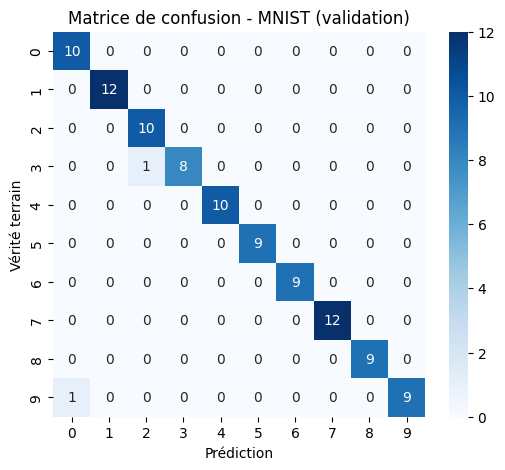

In [ ]:
## TODO récupère les Y_true et Y_pred et crée une matrice de confusion
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(Y_true, Y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Prédiction")
plt.ylabel("Vérité terrain")
plt.title("Matrice de confusion - MNIST (validation)")
plt.show()

### Affichage d'images mal classifiées

Nombre d'images mal classées : 2


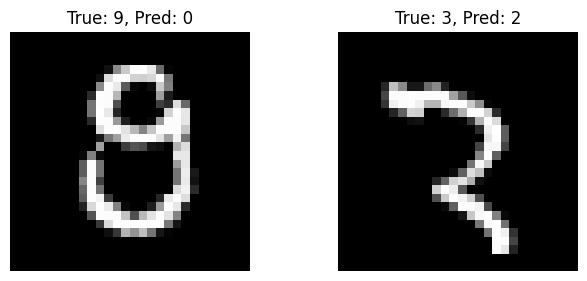

In [ ]:
# TODO Affiche les images dont la prediction n'est pas correcte ainsi que la prédiction et celle attendue

import numpy as np
import matplotlib.pyplot as plt

wrong_idx = np.where(Y_pred != Y_true)[0]

print("Nombre d'images mal classées :", len(wrong_idx))

plt.figure(figsize=(10,8))

for i, idx in enumerate(wrong_idx[:9]):   # on affiche les 9 premières
    plt.subplot(3, 3, i+1)
    plt.imshow(X_val[idx].squeeze(), cmap="gray")
    plt.title(f"True: {Y_true[idx]}, Pred: {Y_pred[idx]}")
    plt.axis("off")

plt.tight_layout()
plt.show()


### Calcule des métriques accuracy, precision, rappel, f1-score

In [ ]:
# TODO calcule les métriques

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

acc  = accuracy_score(Y_true, Y_pred)
prec = precision_score(Y_true, Y_pred, average="macro")
rec  = recall_score(Y_true, Y_pred, average="macro")
f1   = f1_score(Y_true, Y_pred, average="macro")

print(f"Accuracy  : {acc:.4f}")
print(f"Précision : {prec:.4f}")
print(f"Rappel    : {rec:.4f}")
print(f"F1-score  : {f1:.4f}")


Accuracy  : 0.9800
Précision : 0.9818
Rappel    : 0.9789
F1-score  : 0.9793


## Conclusion du projet MNIST

Dans ce projet, nous avons entraîné un réseau de neurones convolutif (CNN) pour reconnaître les chiffres manuscrits du dataset MNIST. Après les étapes de préparation des données (décodage, normalisation, reshape et encodage des labels), le modèle a été entraîné sur 900 images et évalué sur 100 images de validation.

Les résultats obtenus montrent une très bonne performance :

Final loss : 0.17

Final accuracy : 0.98

Nombre d'images mal classées : 2 / 100

Ces performances sont cohérentes avec ce que l'on observe habituellement sur MNIST. La matrice de confusion confirme que la grande majorité des chiffres sont correctement classés, avec seulement deux erreurs, généralement dues à des chiffres manuscrits ambigus ou mal formés.

### Points clés du projet

Le pipeline complet est opérationnel :
Chargement → Prétraitement → CNN → Évaluation

L'utilisation de BatchNormalization, Dropout et d'une stratégie EarlyStopping a permis d'améliorer la stabilité et la généralisation du modèle.

Malgré un dataset volontairement réduit (1000 images), l'accuracy atteint 98%, ce qui démontre l'efficacité de l'architecture CNN choisie.

### Analyse des erreurs

Les deux erreurs de classification observées concernent des cas atypiques :

Un 3 confondu avec un 8, ce qui est courant lorsque les chiffres se ressemblent visuellement.

Un 9 confondu avec un 0, probablement dû à une forme très arrondie.

Ces confusions sont typiques du dataset MNIST et reflètent davantage l'ambiguïté des écritures manuscrites que des limites du modèle.

### Perspectives d'amélioration

Entraîner le modèle sur un nombre plus important d'images (par exemple 10 000 ou 60 000) permettrait d'atteindre une accuracy encore plus élevée (≈ 99%).

Tester des architectures CNN plus profondes.

Ajuster les hyperparamètres : taux d'apprentissage, taille de batch, etc.

Intégrer des techniques de data augmentation pour rendre le modèle plus robuste.

Grâce à cette étude, j'ai mis en œuvre un pipeline Deep Learning complet, permettant de classifier efficacement des chiffres manuscrits. Le modèle obtenu est fiable, performant et constitue une excellente base pour des projets de vision par ordinateur plus complexes.